In [1]:
import sys
sys.path.append('..')

In [2]:
import tensorflow as tf
from tensorflow import keras

from run_utils import setup
from configs import vae_wrapper_config as config
from models import unet
from capsa import VAEWrapper
from callbacks import VisCallback
from utils import notebook_select_gpu, load_depth_data, load_apollo_data, \
    get_normalized_ds, visualize_vae_depth_map

notebook_select_gpu(2, False)

4 Physical GPUs, 1 Logical GPU


In [3]:
(x_train, y_train), (x_test, y_test) = load_depth_data()

ds_train = get_normalized_ds(x_train[:config.N_TRAIN], y_train[:config.N_TRAIN])
ds_test = get_normalized_ds(x_test, y_test)

_, (x_ood, y_ood) = load_apollo_data()
ds_ood = get_normalized_ds(x_ood, y_ood)

In [4]:
model_name = 'notebook_ae'
path, checkpoints_path, vis_path, plots_path, logs_path = setup(model_name)

## Load trained model

In [5]:
from utils import load_model, select_best_checkpoint

path, _ = select_best_checkpoint('/home/iaroslavelistratov/results/ae/20220918-171841-new-latent20')
trained_model = load_model(path, model_name, ds_train, opts={'latent_dim':20}, quite=False) # (4, 5, 8)

encoder-inputs:  (None, 128, 160, 3)
encoder-pool1:  (None, 64, 80, 32)
encoder-pool2:  (None, 32, 40, 64)
encoder-pool3:  (None, 16, 20, 128)
encoder-pool4:  (None, 8, 10, 256)
encoder-pool5:  (None, 4, 5, 256)
encoder-conv6:  (None, 4, 5, 256)
encoder-conv7:  (None, 4, 5, 128)
encoder-conv8:  (None, 4, 5, 64)
encoder_trainable_count 4239624
encoder_non_trainable_count 0
decoder-conv8:  (None, 4, 5, 64)
decoder-conv7:  (None, 4, 5, 128)
decoder-conv6:  (None, 4, 5, 256)
decoder-conv5:  (None, 4, 5, 256)
decoder-conv4:  (None, 8, 10, 256)
decoder-conv3:  (None, 16, 20, 128)
decoder-conv2:  (None, 32, 40, 64)
decoder-conv1:  (None, 64, 80, 32)
decoder-conv0:  (None, 128, 160, 16)
decoder_trainable_count 3509939
decoder_non_trainable_count 0
Successfully loaded weights from /home/iaroslavelistratov/results/ae/20220918-171841-new-latent20/checkpoints/0.008297vloss_51612iter.tf.


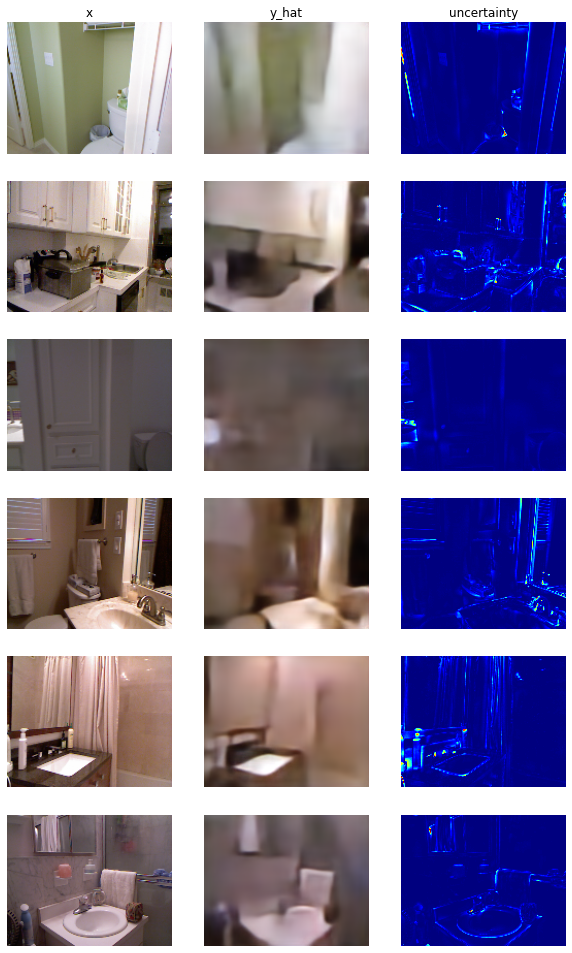

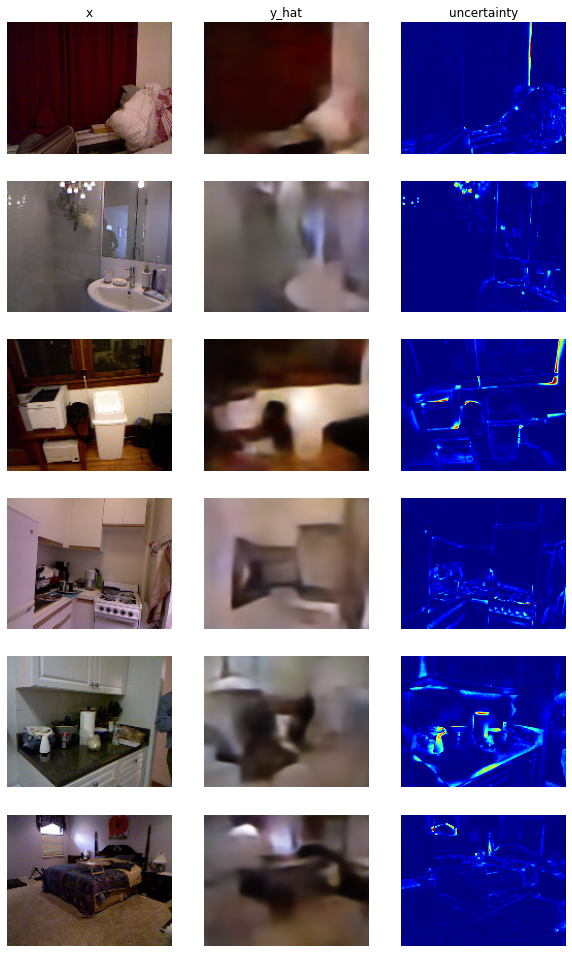

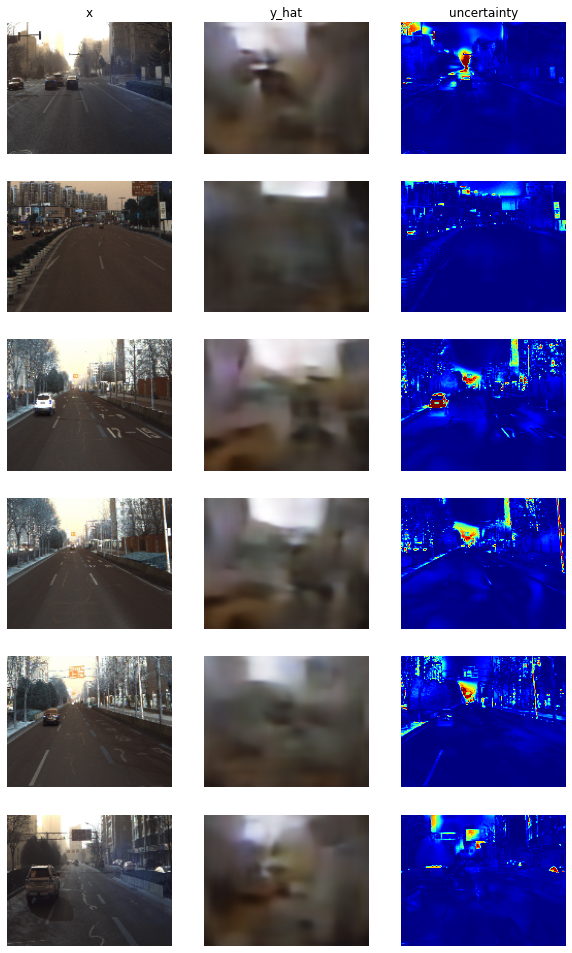

In [6]:
from utils import visualize_vae_depth_map

visualize_vae_depth_map(trained_model, ds_train, vis_path, f'trained_train', is_show=True)
visualize_vae_depth_map(trained_model, ds_test, vis_path, f'trained_test', is_show=True)
visualize_vae_depth_map(trained_model, ds_ood, vis_path, f'trained_ood', is_show=True)

## Calibration curve

In [7]:
# from visualizations import gen_calibration_plot
# gen_calibration_plot(trained_model, ds_test)

In [8]:
# import numpy as np
# import tensorflow as tf
# from scipy import stats
# import matplotlib.pyplot as plt

# mu_ = []
# std_ = []
# y_test_ = []

# # x_test_batch, y_test_batch = iter(ds).get_next()
# for (x_test_batch, y_test_batch) in ds_test:
#     # todo-med: better use model.predict, it's more optimized
#     # y_hat, z_mean, z_log_var
#     y_hats = []

#     for i in range(5):
#         # need training Ture for sampling
#         y_hat, _ = trained_model(x_test_batch, training=True)
#         y_hats.append(y_hat)
#     y_hats = np.stack(y_hats, 0)
#     mu_batch = tf.reduce_mean(y_hats, 0)
#     std_batch = tf.math.reduce_std(y_hats, 0)

#     mu_.append(mu_batch)
#     std_.append(std_batch)
#     y_test_.append(y_test_batch)

# mu = np.concatenate(mu_) #(3029, 128, 160, 1)
# std = np.concatenate(std_) #(3029, 128, 160, 1)
# y_test = np.concatenate(y_test_) #(3029, 128, 160, 1)

# # if isinstance(trained_model, (MVEWrapper, VAE)):
# #     std = np.sqrt(std)

# vals = []
# percentiles = np.arange(41)/40
# for percentile in percentiles:
#     # returns the value at the n% percentile e.g., stats.norm.ppf(0.5, 0, 1) == 0.0
#     # in other words, if have a normal distrib. with mean 0 and std 1, 50% of data falls below and 50% falls above 0.0.
#     ppf_for_this_percentile = stats.norm.ppf(percentile, mu, std) # (3029, 128, 160, 1)
#     vals.append((y_test <= ppf_for_this_percentile).mean()) # (3029, 128, 160, 1) -> scalar

# plt.plot(percentiles, vals)
# plt.plot(percentiles, percentiles)
# plt.title(str(np.mean(abs(percentiles - vals))))
# plt.show()

## OOD plot

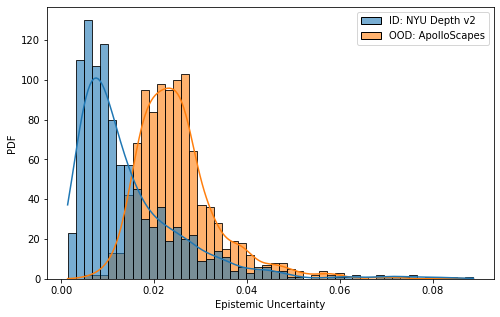

In [9]:
from utils import gen_ood_comparison
gen_ood_comparison(ds_test, ds_ood, trained_model, reduce='per_img', is_show=True)

### Another OOD ds

In [10]:
import pathlib

data_dir = pathlib.Path('/home/iaroslavelistratov/data/ood_miniplaces')
ood_places_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(128, 160),
    batch_size=32,
)

# training_set = training_set.map(lambda image, label: read_images(image), num_parallel_calls=tf.data.experimental.AUTOTUNE)
ood_places_ds = ood_places_ds.map(lambda x, y: (x/255., y))

Found 10000 files belonging to 1 classes.


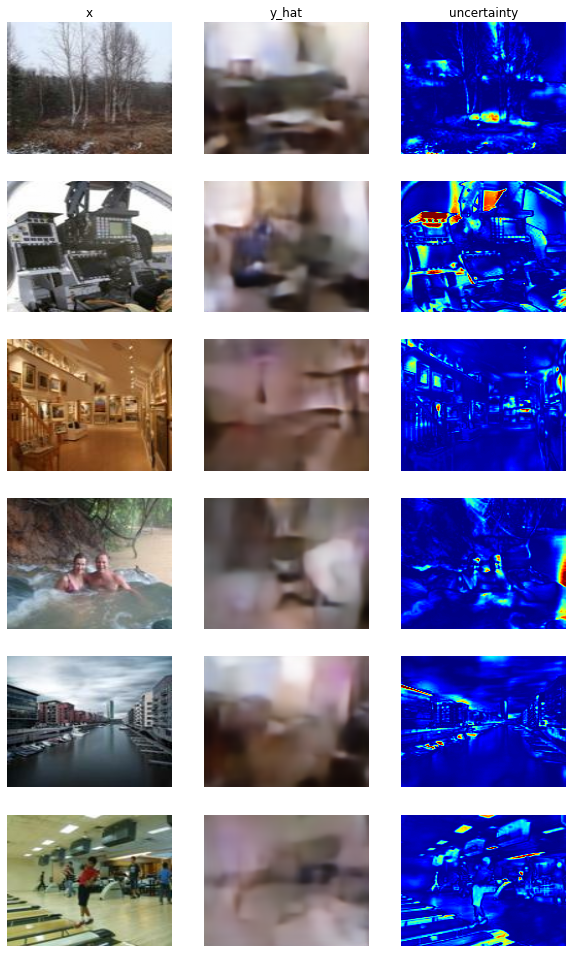

In [11]:
visualize_vae_depth_map(trained_model, ood_places_ds, vis_path, f'trained_ood', is_show=True)

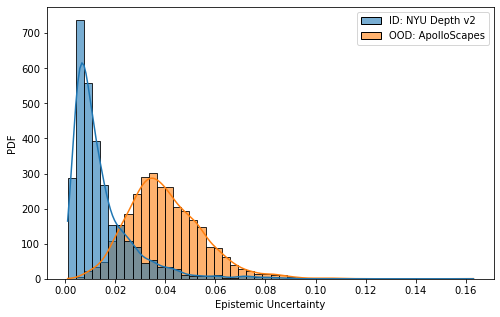

In [12]:
gen_ood_comparison(ds_test, ood_places_ds, trained_model, reduce='per_img', is_show=True)